I read in the normalized EU industry production index time series:

In [1]:
import pandas as pd
df = pd.read_pickle('EU_industry_production_dataframe_normalized_2000-2017.pkl')
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7632 entries, (2000-01-01 00:00:00, AT) to (2017-08-01 00:00:00, UK)
Data columns (total 3 columns):
production_index         7412 non-null float64
flags                    7632 non-null category
production_index_norm    7404 non-null float64
dtypes: category(1), float64(2)
memory usage: 155.5+ KB
                         production_index flags  production_index_norm
time       country_code                                               
2000-01-01 AT                        73.0                     0.763119
           BA                         NaN                          NaN
           BE                        63.1                     0.659628
           BG                        61.1                     0.638720
           CY                       103.0                     1.076730


To get a better view at the individual time series, I split the 36 curves into two plots. I select first only the first half and then only the second half of the country columns using the "iloc" locator:

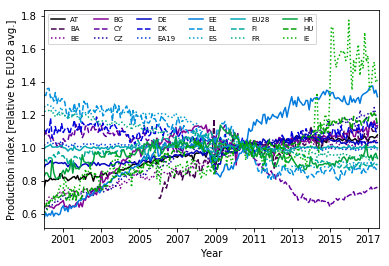

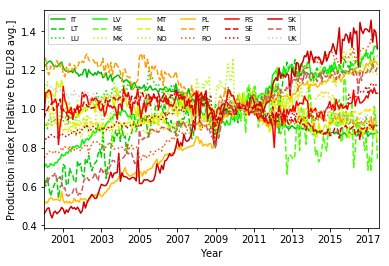

In [2]:
import matplotlib.pyplot as plt
import numpy as np

################# First figure
fig, ax = plt.subplots()        # Create figure and axes objects

# Reset line properties to avoid ambiguity between different lines:
ax.set_prop_cycle(color=plt.cm.nipy_spectral(np.linspace(0,1,36)),linestyle=['-','--',':']*12)

# Create the plot:
ax = df['production_index_norm'].unstack(level=1).iloc[:,0:18].plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Production index [relative to EU28 avg.]')
ax.legend(ncol=6, fontsize=7)   # Adjust shape (four columns instead of one) and font size of legend
plt.show()

################# Second figure
fig, ax = plt.subplots()        # Create figure and axes objects

# Reset line properties to avoid ambiguity between different lines:
ax.set_prop_cycle(color=plt.cm.nipy_spectral(np.linspace(0.5,1,18)),linestyle=['-','--',':']*6)

# Create the plot:
ax = df['production_index_norm'].unstack(level=1).iloc[:,18:].plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Production index [relative to EU28 avg.]')
ax.legend(ncol=6, fontsize=7)   # Adjust shape (four columns instead of one) and font size of legend
plt.show()

Though there are a few curves that show more complex long-term dynamics (e.g., Cyprus), the vast majority can be described as roughly linear plus some short- to mid-scale fluctuations.

This motivates a linear approximation of the time series. In such a simple model, y = m * * x + b, the production index (y) depends on the time (x) and on two parameters: m gives the slope of the line and is thus a measure of the growth that I am looking for, b is the production index value at time zero (the intercept).

Time zero is a bit unpractical though when using the calendar year to express time. A more natural approach would be to count years from the reference point of the dataset, that is the year 2010.

How do I get a linear approximation of the time series? What I want is to find those values for m and b that minimize the sum of squared distances between the line and the real production index at each time (sum of squared residuals). This process is called linear regression.

Since y does only depend on one variable (x) in this case, I could use the numpy method "polyfit()" for this task.

In the spirit of a more general answer that would also work for more complex datasets (y depending on many variables), I opt to use the linear regression method in the scikitlearn package though.


Before performing the linear regression in the next project, I make the transformation of the time axis and unstack the "country_code" index level:

In [3]:
# Unstack country_code index into columns:
df_forregression = df['production_index_norm'].unstack(level=1).copy()

# Reset DatetimeIndex to FloatIndex (counting years from 2010):
df_forregression.set_index((df_forregression.index - pd.Timestamp('2010-01-01')) / pd.Timedelta(365.25, unit='d'), inplace=True)
print(df_forregression.info())
print(df_forregression.head())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 212 entries, -10.0013689254 to 7.58110882957
Data columns (total 36 columns):
AT      211 non-null float64
BA      139 non-null float64
BE      211 non-null float64
BG      211 non-null float64
CY      211 non-null float64
CZ      211 non-null float64
DE      211 non-null float64
DK      211 non-null float64
EA19    211 non-null float64
EE      211 non-null float64
EL      211 non-null float64
ES      211 non-null float64
EU28    211 non-null float64
FI      211 non-null float64
FR      211 non-null float64
HR      211 non-null float64
HU      211 non-null float64
IE      211 non-null float64
IT      211 non-null float64
LT      211 non-null float64
LU      211 non-null float64
LV      211 non-null float64
ME      91 non-null float64
MK      211 non-null float64
MT      211 non-null float64
NL      211 non-null float64
NO      211 non-null float64
PL      211 non-null float64
PT      211 non-null float64
RO      211 non-null float64
R

Subtracting one "DateTime" object from another (the DateTimeIndex) produces a "Timedelta" object, with the unit "days". Note that the "Timedelta" objects cannot be exactly converted into years or months, because these quantities vary in length (e.g., leap years).

For my basic analysis, such details are, however, negligible and so I divide by 365.25 days to obtain a Float64Index with values that can be interpreted as years: The range is from -10 (10 years before 2010) and 7.5 (7.5 years after 2010).

In [4]:
df_forregression.to_pickle('EU_industry_production_dataframe_forregression.pkl')